In [1]:
import os
import csv

ROOT = "./results"

model_names = [
    "llm-jp-3-13b-exp1-ja", 
    "llm-jp-3-13b-exp3-balanced-ja", 
    "llm-jp-3-13b-exp3-science-ja", 
    "llm-jp-3-13b-exp3-medical-ja"]

template = "minimal"
num_shot = 0
train_lang = "ja"
prompt_tasks = [
        "nii_en5_mono_prompt-en", "nii_en5_mono_prompt-ja",
        "nii_en5_bi_prompt-en", "nii_en5_bi_prompt-ja",
        "nii_en5_tri_prompt-en", "nii_en5_tri_prompt-ja",
        "nii_ja5_mono_prompt-en", "nii_ja5_mono_prompt-ja",
        "nii_ja5_bi_prompt-en", "nii_ja5_bi_prompt-ja",
        "nii_ja5_tri_prompt-en", "nii_ja5_tri_prompt-ja"]

In [2]:
import re
import pandas as pd
from torch import mode

accs = []
for model_name in model_names:
    result_dir = os.path.join(ROOT, f"{model_name}_{template}_{str(num_shot)}-shot")

    for filename in os.listdir(result_dir):
        if not filename.endswith(".csv"):
            continue
        result_filename = os.path.join(result_dir, filename)
        if not os.path.isfile(result_filename):
            continue 
        matches = re.match(r"prompt.csv", filename)
        if not matches:
            continue
            # raise ValueError(f"Invalid filename format: {filename}")

        with open(result_filename, 'r') as csvfile:
            reader = csv.reader(csvfile)
            header = next(reader)
            for row in reader:
                task, acc = row[0], row[3]
                if (task.endswith("ja") and template == "english") or (task.endswith("en") and template == "standard"):
                    continue
                
                eval_src_lang = "ja" if task.startswith("nii_ja") else "en"
                eval_lang = "ja" if task.endswith("ja") else "en"
                accs.append({
                    "model_name": model_name,
                    "template-lang": "ja" if template == "standard" else "en",
                    # "template-lang": "none",
                    "train-lang": train_lang,
                    "src-eval-lang": eval_src_lang,
                    "eval-lang": eval_lang,
                    "identifier": f"{train_lang}-{eval_src_lang}-{eval_lang}",
                    "prompt-type": task.split("_")[2] + "-sentence",
                    "task": task,
                    "task-prefix": task.split("-")[0],
                    "acc": round(float(acc), 4),
                })
    df = pd.DataFrame(accs)

In [3]:
model_alias, delta_accs = [], []
for idx, row in df.iterrows():
    _df = df[(df["prompt-type"] == row["prompt-type"]) & (df["identifier"] == row["identifier"]) & (df["model_name"] == "llm-jp-3-13b-exp1-ja")]
    assert len(_df) == 1
    delta_accs.append(row['acc'] - _df.iloc[0]['acc'])
    if row["model_name"] == "llm-jp-3-13b":
        model_alias.append("raw model")
    elif row["model_name"] == "llm-jp-3-13b-exp1-ja":
        model_alias.append("0.5B Ja KG")
    elif row["model_name"] == "llm-jp-3-13b-exp3-balanced-ja":
        model_alias.append("0.5B Ja KG + 0.5B Balanced CT")
    elif row["model_name"] == "llm-jp-3-13b-exp3-science-ja":
        model_alias.append("0.5B Ja KG + 0.5B Science CT")
    elif row["model_name"] == "llm-jp-3-13b-exp3-medical-ja":
        model_alias.append("0.5B Ja KG + 0.5B Medical CT")

df["delta_acc"] = delta_accs
df["model_alias"] = model_alias
df = df[df["model_name"] != "llm-jp-3-13b-exp1-ja"]

In [4]:
from turtle import title
import seaborn as sns
import matplotlib.pyplot as plt

def plot_acc(_df, title):
    plt.figure(figsize=(7, 4))
    sns.barplot(data=_df, x='model_alias', y='delta_acc', hue='identifier')
    plt.xticks(rotation=10)
    plt.title(title)
    plt.xlabel("Model Name")
    plt.ylabel("Accuracy Difference to Baseline")
    plt.grid(axis='y')
    plt.legend(title='Train-SrcEval-Eval Langs', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title_fontsize=12)
    plt.tight_layout()
    plt.show()

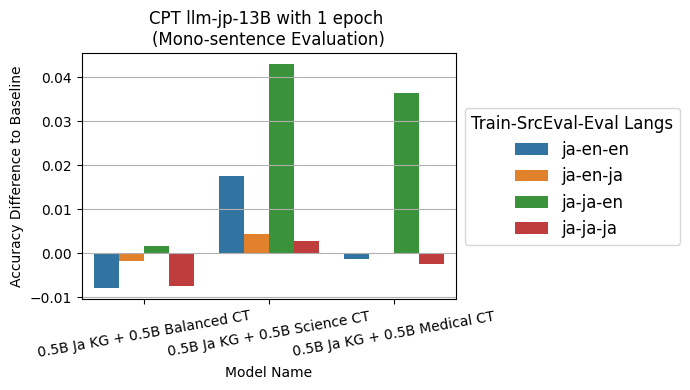

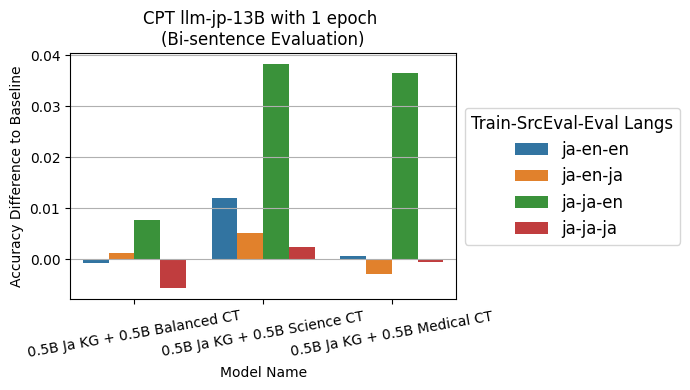

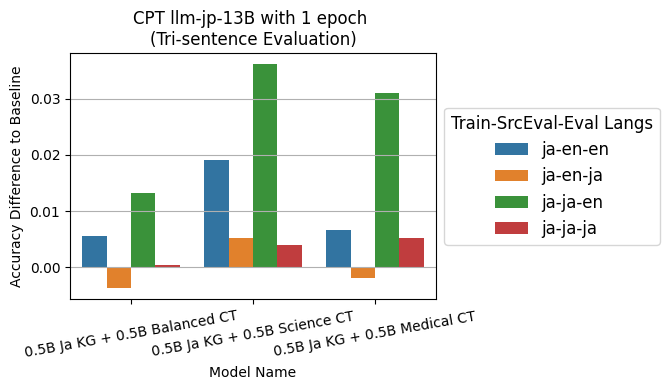

In [5]:

_df = df[df["task-prefix"].str.contains("mono")]
plot_acc(_df, "CPT llm-jp-13B with 1 epoch \n(Mono-sentence Evaluation)")

_df = df[df["task-prefix"].str.contains("bi")]
plot_acc(_df, "CPT llm-jp-13B with 1 epoch \n(Bi-sentence Evaluation)")

_df = df[df["task-prefix"].str.contains("tri")]
plot_acc(_df, "CPT llm-jp-13B with 1 epoch \n(Tri-sentence Evaluation)")